In [1]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import Normalizer, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

Загрузим и подготовим данные

In [2]:
info = pd.read_csv('matches_info_4_4.csv')
meta = pd.read_csv('matches_meta_4_4.csv')

In [3]:
meta.drop_duplicates(inplace=True)
meta.value_counts("matchId").sort_values(ascending=False)

matchId
NA1_4234668610    1
NA1_4234676520    1
NA1_4234678037    1
NA1_4234685183    1
NA1_4234695909    1
                 ..
NA1_4260902215    1
NA1_4260902510    1
NA1_4260903597    1
NA1_4260903696    1
NA1_4260911107    1
Length: 8193, dtype: int64

In [4]:
merged = pd.merge(info, meta[["matchId","gameLength","winningTeam"]],how="inner",on="matchId")

In [5]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8191 entries, 0 to 8190
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   matchId          8191 non-null   object
 1   t1Dragons        8191 non-null   int64 
 2   t2Dragons        8191 non-null   int64 
 3   t1Rift           8191 non-null   int64 
 4   t2Rift           8191 non-null   int64 
 5   topGoldDiff      8191 non-null   int64 
 6   jgGoldDiff       8191 non-null   int64 
 7   midGoldDiff      8191 non-null   int64 
 8   adcGoldDiff      8191 non-null   int64 
 9   suppGoldDiff     8191 non-null   int64 
 10  t1TopTowerTaken  8191 non-null   int64 
 11  t1MidTowerTaken  8191 non-null   int64 
 12  t1BotTowerTaken  8191 non-null   int64 
 13  t2TopTowerTaken  8191 non-null   int64 
 14  t2MidTowerTaken  8191 non-null   int64 
 15  t2BotTowerTaken  8191 non-null   int64 
 16  gameLength       8191 non-null   int64 
 17  winningTeam      8191 non-null   

In [6]:
def winningConvert(x):
    if x == 100:
        return 1
    else:
        return 0

merged["winningTeam"] = merged["winningTeam"].apply(winningConvert)

In [7]:
merged.head()

,matchId,t1Dragons,t2Dragons,t1Rift,t2Rift,topGoldDiff,jgGoldDiff,midGoldDiff,adcGoldDiff,suppGoldDiff,t1TopTowerTaken,t1MidTowerTaken,t1BotTowerTaken,t2TopTowerTaken,t2MidTowerTaken,t2BotTowerTaken,gameLength,winningTeam
0,NA1_4246867983,2,0,0,0,2336,-1008,1383,731,683,0,0,0,1,0,0,1752,1
1,NA1_4249810674,1,1,0,1,936,1694,216,1817,2023,0,0,0,0,0,1,925,1
2,NA1_4260329763,0,2,0,1,-846,-1472,-5485,-2755,-339,1,2,2,0,0,0,911,0
3,NA1_4253638363,0,1,1,0,1312,397,1266,486,874,0,0,0,1,0,0,2800,0
4,NA1_4259164367,0,1,0,1,-1981,2913,-114,83,-226,1,0,0,0,0,0,2189,0


Будем предсказывать победившую команду

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(merged.drop(["matchId","winningTeam","gameLength"],axis=1), 
                                                    merged["winningTeam"], test_size=0.3, random_state=10)

Введем функцию для анализа точности моделей

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

def scores(model, data, labels):
    pred = model.predict(data)
    print('Accuracy:', accuracy_score(labels, pred))
    print('Precision:', precision_score(labels, pred))
    print('Recall:', recall_score(labels, pred))
    figure = plt.figure(figsize=(12, 4))
    matrix = confusion_matrix(labels, pred)
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay(matrix).plot(ax=ax)
    plt.subplots_adjust(wspace=0.3)
    plt.show()

## Логистическая регрессия

In [10]:
import warnings

class Logistic_Regression(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.1, batch=10, epochs=1, alpha=0.0001):
        self.lr = lr
        self.batch = batch
        self.epochs = epochs
        self.alpha = alpha
    
    def fit(self, data, labels):
        self.w = np.random.normal(0, 1, (data.shape[1]+1,))
        data = np.concatenate((data, np.ones((data.shape[0],1))), axis=1)
        for _ in range(self.epochs):
            for i in range(self.batch, len(data), self.batch):
                data_batch = data[i-self.batch:i]
                labels_batch = labels[i-self.batch:i]
                
                pred = self.sigmoid(np.dot(self.w, data_batch.T))
                grad = 2 * self.alpha * self.w + np.dot(pred - labels_batch, data_batch)
                
                self.w -= self.lr * grad
        return self
    
    def sigmoid(self, x):
        warnings.filterwarnings('ignore')
        return 1 / (1 + np.exp(-x))
    
    def predict(self, data):
        return (self.sigmoid(np.concatenate((data, np.ones((data.shape[0],1))), axis=1).dot(self.w)) > 0.5).astype('int64')

In [11]:
gcv = GridSearchCV(Pipeline([('normalizer', Normalizer()), ('log', Logistic_Regression())]),
                    {'log__lr': [0.1, 0.01, 0.001], 'log__epochs': [1, 10, 100], 
                     'log__batch': [10, 100, 1000], 'log__alpha': [0.01, 0.001, 0.0001]})
gcv.fit(X_train, y_train)
print(gcv.best_params_, gcv.best_score_, sep='\n')

{'log__alpha': 0.0001, 'log__batch': 10, 'log__epochs': 100, 'log__lr': 0.01}
0.7488224079509336


Accuracy: 0.7506102522375916
Precision: 0.7332820906994619
Recall: 0.7819672131147541


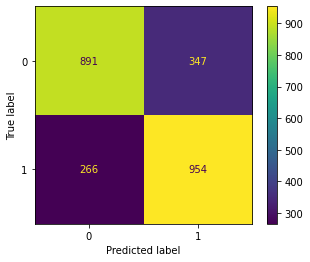

In [12]:
log = gcv.best_estimator_
scores(log, X_test, y_test)

In [13]:
f = open("log.pkl", "wb")
pickle.dump(log, f, pickle.HIGHEST_PROTOCOL)
f.close()

Сравним c логистической регрессией из sklearn

In [14]:
from sklearn.linear_model import LogisticRegression

gcv = GridSearchCV(Pipeline([('logreg', LogisticRegression())]),
                    {"logreg__penalty" : ["l2", "none"],
                     "logreg__solver" : ["newton-cg", "lbfgs"]})

gcv.fit(X_train, y_train)
print(gcv.best_params_, gcv.best_score_, sep='\n')

{'logreg__penalty': 'none', 'logreg__solver': 'lbfgs'}
0.7556273212919049


Accuracy: 0.7473555736371034
Precision: 0.7341673182173573
Recall: 0.769672131147541


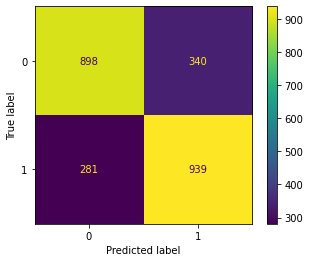

In [15]:
log = gcv.best_estimator_
scores(log, X_test, y_test)

## KNN

In [16]:
class KNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k=5):
        self.k = k
    
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        return self
    
    def predict(self, data):
        res = np.ndarray((data.shape[0],))
        for i, x in enumerate(data):
            neighbors = np.argpartition(((self.data - data[i]) ** 2).sum(axis=1), self.k - 1)[:self.k]
            values, counts = np.unique(self.labels[neighbors], return_counts=True)
            res[i] = values[counts.argmax()]
        return res

In [17]:
gcv = GridSearchCV(Pipeline([('scaler', StandardScaler()), ('knn', KNN())]),
                    {'knn__k': range(25)})
gcv.fit(X_train.to_numpy(), y_train.to_numpy())
print(gcv.best_params_, gcv.best_score_, sep='\n')

{'knn__k': 21}
0.7275423709472013


Accuracy: 0.7306753458096013
Precision: 0.7203791469194313
Recall: 0.7475409836065574


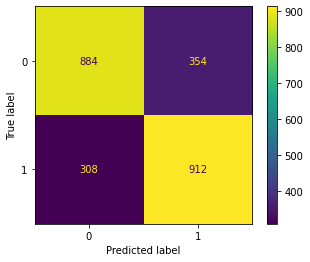

In [18]:
kn = gcv.best_estimator_
scores(kn, X_test, y_test)

In [19]:
f = open("knn.pkl", "wb")
pickle.dump(kn, f, pickle.HIGHEST_PROTOCOL)
f.close()

Сравним с KNN из sklearn

In [20]:
from sklearn.neighbors import KNeighborsClassifier

gcv = GridSearchCV(Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]),
                    {'knn__n_neighbors': range(25)})
gcv.fit(X_train, y_train)
print(gcv.best_params_, gcv.best_score_, sep='\n')

{'knn__n_neighbors': 18}
0.7271957652636593


Accuracy: 0.7282343368592351
Precision: 0.7379310344827587
Recall: 0.7016393442622951


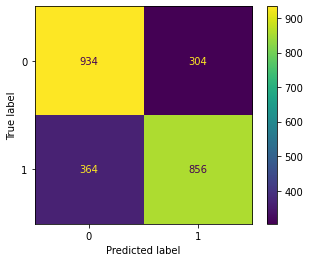

In [21]:
kn = gcv.best_estimator_
scores(kn, X_test, y_test)

## NaiveBayes

In [22]:
class NaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self, bins):
        self.bins = bins
        pass
    
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        self.classes = []
        for j in np.unique(labels):
            
            self.classes.append([])
            for i in range (data.shape[1]):
                self.classes[j].append([*np.histogram(data[labels == j, i], bins = self.bins)])
                self.classes[j][-1][0] = self.classes[j][-1][0].astype('float64') / len(data[labels == j, i])
        
        self.prclasses = np.unique(labels, return_counts = True)[1] / len(labels)
        
    def predict(self, maindata):
        res = np.ndarray((maindata.shape[0],))
        for j, data in enumerate(maindata):
            maximum = 0
            ans = 0
            for i in range(len(self.classes)):
                p = self.prclasses[i]
                for k in range(len(self.classes[i])):
                    ind = np.digitize(data[k], self.classes[i][k][1])
                    
                    if ind >= len(self.classes[i][k][1]) or ind <= 0:
                        p = 0
                    else:
                        p *= self.classes[i][k][0][ind - 1]
                    
                if p > maximum:
                    maximum = p
                    ans = i
            res[j] = ans
        return res

In [23]:
gcv = GridSearchCV(Pipeline([('normalizer', Normalizer()), ('nb', NaiveBayes(10))]),
                    {'nb__bins': range(50)})
gcv.fit(X_train.to_numpy(), y_train.to_numpy())
print(gcv.best_params_, gcv.best_score_, sep='\n')

{'nb__bins': 3}
0.7090514598368002


Accuracy: 0.7168429617575265
Precision: 0.6829608938547486
Recall: 0.8016393442622951


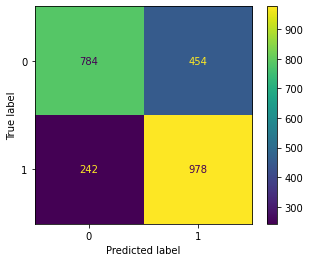

In [24]:
nb = gcv.best_estimator_
scores(nb, X_test, y_test)

In [25]:
f = open("nb.pkl", "wb")
pickle.dump(nb, f, pickle.HIGHEST_PROTOCOL)
f.close()

Теперь оно же, но из sklearn

Accuracy: 0.7164361269324654
Precision: 0.7060677698975572
Recall: 0.7344262295081967


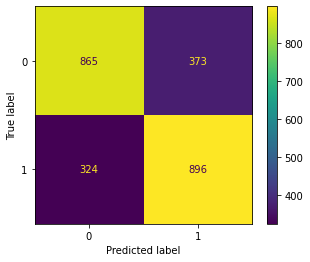

In [26]:
from sklearn.naive_bayes import GaussianNB

nb = Pipeline([('nb', GaussianNB())])
nb.fit(X_train, y_train)
scores(nb, X_test, y_test)

## SVM

In [27]:
class SVM(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.1, batch=10, epochs=1, alpha=0.0001):
        self.lr = lr
        self.batch = batch
        self.epochs = epochs
        self.alpha = alpha
    
    def fit(self, data, labels):
        self.w = np.random.normal(0, 1, (data.shape[1]+1,))
        data = np.concatenate((data, np.ones((data.shape[0],1))), axis=1)
        labels = labels * 2 - 1
        for _ in range(self.epochs):
            for i in range(self.batch, len(data), self.batch):
                data_batch = data[i-self.batch:i]
                labels_batch = labels[i-self.batch:i]
                
                grad = 2 * self.alpha * self.w
                for i, x in enumerate(data_batch):
                    if 1 - x.dot(self.w) * labels_batch[i] > 0:
                        grad -= x * labels_batch[i]
                
                self.w -= self.lr * grad
        return self

    def predict(self, data):
        return (np.sign(np.concatenate((data, np.ones((data.shape[0],1))), axis=1).dot(self.w)) + 1) / 2

In [28]:
gcv = GridSearchCV(Pipeline([('scaler', StandardScaler()), ('svm', SVM())]),
                    {'svm__lr': [0.1, 0.01, 0.001], 'svm__epochs': [1, 10, 100], 
                     'svm__batch': [10, 100, 1000], 'svm__alpha': [0.01, 0.001, 0.0001]})
gcv.fit(X_train.to_numpy(), y_train.to_numpy())
print(gcv.best_params_, gcv.best_score_, sep='\n')

{'svm__alpha': 0.001, 'svm__batch': 1000, 'svm__epochs': 10, 'svm__lr': 0.001}
0.7561513379618429


Accuracy: 0.7457282343368592
Precision: 0.7370517928286853
Recall: 0.7581967213114754


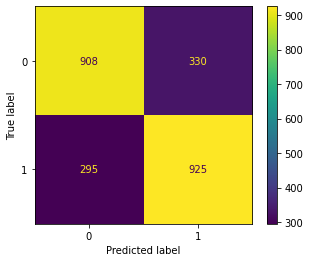

In [29]:
svm = gcv.best_estimator_
scores(svm, X_test, y_test)

In [30]:
f = open("svm.pkl", "wb")
pickle.dump(svm, f, pickle.HIGHEST_PROTOCOL)
f.close()